In [1]:
import numpy as np
from astropy.modeling.blackbody import blackbody_lambda
from astropy import units as u
from astropy import constants as const
import simmetis as sim
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Number of photons on the detector

In [2]:
cmd = sim.UserCommands("metis_image_generic.config")
cmd["FPA_QE"] = "../data/TC_detector_METIS_LM.dat"
cmd["SIM_DETECTOR_PIX_SCALE"] = 0.00525
cmd["SCOPE_PSF_FILE"] = "PSF_diffraction_limited_4.0_microns.fits"
cmd["FPA_QE"] = "TC_detector_METIS_LM.dat"
cmd["FPA_CHIP_LAYOUT"] = "FPA_chip_layout.dat"

metis_filter_id="Lp"
cmd["INST_FILTER_TC"]="TC_filter_" + metis_filter_id + ".dat"

In [3]:
opt = sim.OpticalTrain(cmd)

In [4]:
fpa = sim.Detector(cmd, small_fov=False)

In [5]:
## generate a source with 0 mag and dither
lam, spec = sim.source.flat_spectrum(0, "TC_filter_" + metis_filter_id + ".dat")

src = sim.Source(lam=lam, spectra=np.array([spec]), 
                 ref=[0], x=[0], y=[0])

dither_offset=1 ## offsets in arcseconds
src_dither = sim.Source(lam=lam, spectra=np.array([spec]), 
                 ref=[0], x=[0], y=[dither_offset])

#### Undo dither movement (will preserve noise properties)

In [6]:
src.apply_optical_train(opt, fpa)
hdu = fpa.read_out()
src_dither.apply_optical_train(opt,fpa)
hdu_dither = fpa.read_out()

Generating image for chip 1
Reading out chip 1 using superfast
1.28313175122e+12 263365.718643 7279371437.72 263365.718647
1.28313e+12 260817.0 7.27935e+09 263389.0
Generating image for chip 1
Reading out chip 1 using superfast
1.28313175122e+12 263365.718643 7279371437.72 263365.718647
1.28313e+12 260697.0 7.27931e+09 263389.0


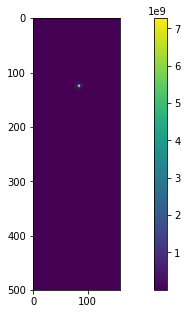

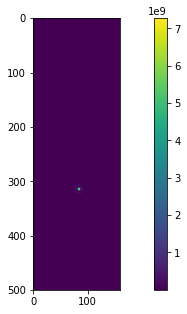

In [7]:
##
## Frame 1
plt.figure(figsize=(12,5))
frame1=hdu[0].data[900:1400,940:1100]
plt.imshow(frame1, interpolation="none")
plt.colorbar()
##
## Dither position (frame 2)
plt.figure(figsize=(12,5))
frame2=hdu_dither[0].data[900:1400,940:1100]
plt.imshow(frame2, interpolation="none")
plt.colorbar()

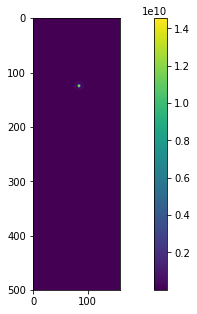

In [8]:
## Shift the dithered image back to the original position and combine the two images
frame_sum=frame1+np.roll(frame2,np.int(np.round(-dither_offset/cmd["SIM_DETECTOR_PIX_SCALE"])),axis=0)
plt.figure(figsize=(12,5))
plt.imshow(frame_sum)
plt.colorbar()